In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
from matplotlib import colors
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f

In [2]:
boundary_p1 = {}
boundary_p1["m"] = Float(5)
boundary_p2 = {}
boundary_p2["m"] = Float(10)
def boundary_generator(points, params):
    return params["m"] * points[0]

In [3]:
rad = 1
bbox = [[-1.05 * rad, -1.05 * rad], [1.05 * rad, 1.05 * rad]]
resolution_image = [256, 256]
spp_image = 256
epsilon = 1e-5
dirichlet = ConstantCoefficient("dirichlet", 0)
σ = ConstantCoefficient("screening", 10)
dirichlet1 = FunctionCoefficient("dirichlet", boundary_p1, boundary_generator)
dirichlet2 = FunctionCoefficient("dirichlet", boundary_p2, boundary_generator)
f = ConstantCoefficient("source", 0)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet1, dirichlet2])
data_holder = DataHolder(shape = shape, σ = σ, f=f)
conf_numbers = [UInt32(0), UInt32(1)]

In [4]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WosConstant(data_holder, seed = 0)
L_wos, p = wos.solve(points_in = points, L_in = 0, mode = dr.ADMode.Primal, dL = 0, conf_numbers=conf_numbers)
image_wos, tensor_wos = create_image_from_result(L_wos, resolution_image)

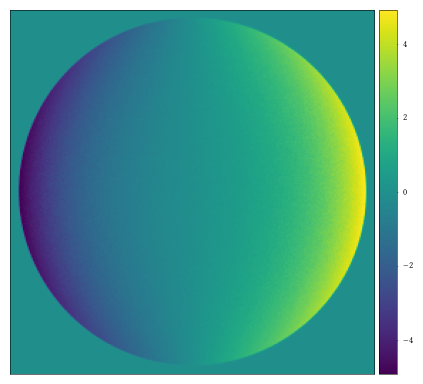

In [5]:
fig, (ax1) = plt.subplots(1,1, figsize = (5,5))
plot_image(image_wos[0], ax1)

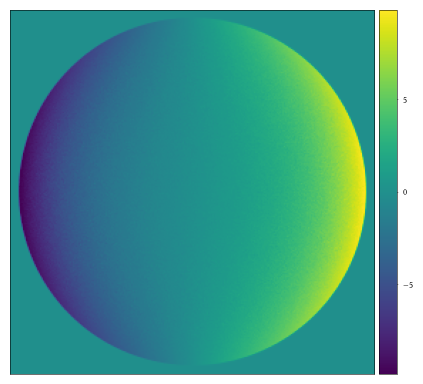

In [6]:
fig, (ax1) = plt.subplots(1,1, figsize = (5,5))
plot_image(image_wos[1], ax1)

In [7]:
rad_der = 0.3
res = 128
spp_der = 2 ** 20
fd_step = 5e-3
points = create_circle_points(radius = rad_der, resolution = res, spp = spp_der)
derivative_dir = points / dr.norm(points)
derivative_dir2 =Point2f(-derivative_dir[1], derivative_dir[0])

In [8]:
derL, _ = wos.solve(points_in = points, derivative_dir = derivative_dir, conf_numbers=conf_numbers)
derSim, _ = create_circle_from_result(derL, res)

In [9]:
points_fd1 = points + derivative_dir * fd_step / 2
points_fd2 = points - derivative_dir * fd_step / 2 
L_fd1, _ = wos.solve(points_in = points_fd1, conf_numbers=conf_numbers)
L_fd2, _ = wos.solve(points_in = points_fd2, conf_numbers=conf_numbers)
derFD, _ = create_circle_from_result((L_fd1 - L_fd2)/fd_step, res)

In [10]:
derFD.shape

(2, 128)

Text(0.5, 1.0, 'Radial Derivative Comparison')

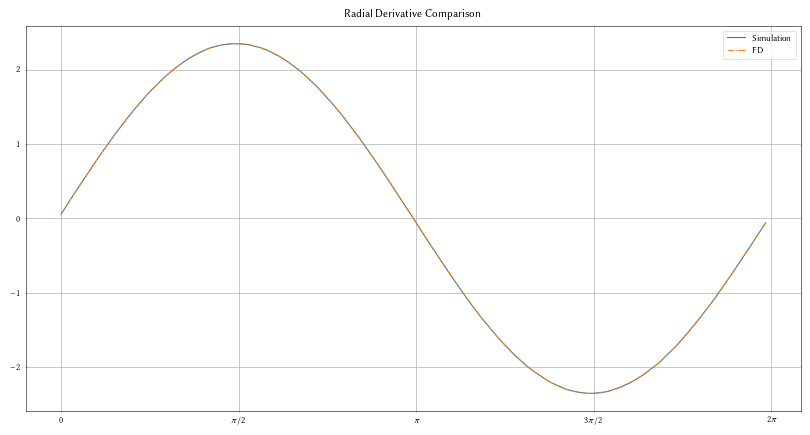

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, derSim[0], label = "Simulation")
ax.plot(angle, derFD[0], label = "FD", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")

Text(0.5, 1.0, 'Radial Derivative Comparison')

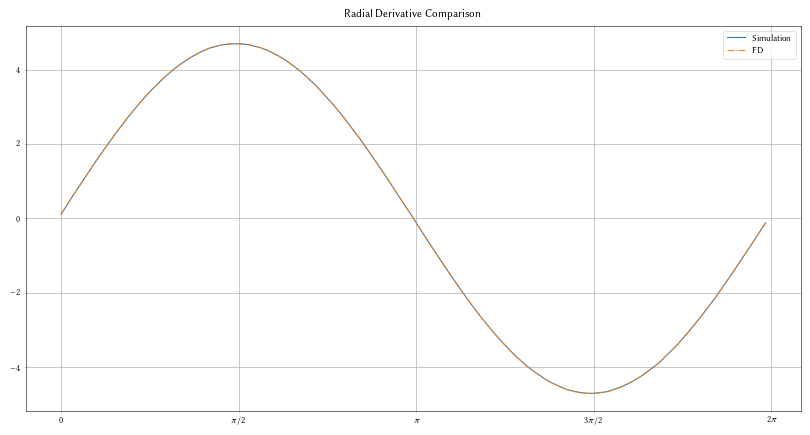

: 

In [12]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, derSim[1], label = "Simulation")
ax.plot(angle, derFD[1], label = "FD", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")